In [238]:
import json
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import ScalarFormatter
import statistics as stat

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH=12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

FIXED_COLOR  = 'tbd'
STATIC_COLOR = 'tbd'
DYNAMIC_COLOR= 'tbd'

FIXED_MARKER='tbd'
STATIC_MARKER='tbd'
DYNAMIC_MARKER='tbd'

In [239]:


experiments_true = [
    'true-run_rs1',
    'true-run_rs2',
    'true-run_rs3',
    'true-run_rs4',
    'true-run_rs5',
    'true-run_rs6',
    'true-run_rs7',
    'true-run_rs8',
    'true-run_rs9',
    'true-run_rs10',
]

experiments = [
    'dynLns_r1',
    'dynLns_r3',
    'dynLns_r4',
    'dynLns_r5',
    'dynLns_r6',
    'dynLns_r7',
    'dynLns_r8',
    'dynLns_r9',
    'dynLns_r10',
]

experiment_ss = [
    'ss-true_rs1',
    'ss-true_rs2',
    'ss-true_rs3',
    'ss-true_rs4',
    'ss-true_rs5',
    'ss-true_rs6',
    'ss-true_rs7',
    'ss-true_rs8',
    'ss-true_rs9',
]
root_path = '/Users/yzamora/Desktop/proxima_analysis/proxima_data'

In [240]:
rog_hf = defaultdict(list)
run_name = 'random-seed_runs/hf_rog'
file = "/".join([root_path, run_name,'result*'])
for f in glob.glob(file):
    control_fn = os.path.basename(f).split('_')
    temp = control_fn[1].split(".json")[0]
    with open(f) as data:
        rog_hf[temp].append(
            json.loads(
                data.read()
            ).get("r_g", None).get("statistic", None)
        )
        
temps = []; rogs_median = []; rogs_std = []
for k, v in rog_hf.items():
    temps.append(float(k))
    rogs_median.append(np.median(v))
    rogs_std.append(np.std(v)/np.sqrt(len(v)-1))

temps, rogs_median, rogs_std = zip(*sorted(zip(temps, rogs_median, rogs_std)))

## ROG results for true simulations

In [241]:
rog_dynLns = defaultdict(list)

## True runs - MC simulations not using reference data, running Proxima, lazy training, no surrogate limit
## dynLNS - Proxima, with reference data (lazy training, no surrogate limit)
#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/true-run*'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_dynLns[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_dynLns = []; rogs_dynLns_median = []; rogs_dynLns_std = []
for k, v in rog_dynLns.items():
    temps_dynLns.append(float(k))
    rogs_dynLns_median.append(np.median(v))
    rogs_dynLns_std.append(np.std(v)/np.sqrt(len(v)))

temps_dynLns, rogs_dynLns_median, rogs_dynLns_std = zip(
    *sorted(zip(temps_dynLns, rogs_dynLns_median, rogs_dynLns_std))
)

## ROG results for Simple surrogate 
Fixed Parameters - 0.3, 50

In [242]:
rog_SS = defaultdict(list)

## True runs - MC simulations not using reference data, running Proxima, lazy training, no surrogate limit
## dynLNS - Proxima, with reference data (lazy training, no surrogate limit)
#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/ss-true*'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_SS[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_SS = []; rogs_SS_median = []; rogs_SS_std = []
for k, v in rog_SS.items():
    temps_SS.append(float(k))
    rogs_SS_median.append(np.median(v))
    rogs_SS_std.append(np.std(v)/np.sqrt(len(v)))

temps_SS, rogs_SS_median, rogs_SS_std = zip(
    *sorted(zip(temps_SS, rogs_SS_median, rogs_SS_std))
)

In [243]:
rogs_SS_median

(0.27303100597047286,
 0.2734019191365427,
 0.27363644447550195,
 0.27385818189664973,
 0.2740792518199058,
 0.274236627974366,
 0.2745244071657063,
 0.27458407609548147,
 0.27494989372875056,
 0.27500237578410996)

In [244]:
good_std = np.std([r for r in rog_dynLns['400'] if r < 0.275])

In [245]:
good_mean = np.median([r for r in rog_dynLns['400'] if r < 0.275])

In [246]:
full_std = np.std([r for r in rog_dynLns['400'] if r < 0.4])
full_mean = np.median([r for r in rog_dynLns['400'] if r < 0.4])

In [247]:
outlier = 0.2784916750097781 
(outlier - full_mean)/full_std

3.3079459184550775

In [248]:
outlier = 0.2784916750097781 
(outlier - good_mean)/good_std

19.618690558621616

In [249]:
mylist = [r for r in rog_dynLns['400'] if r < 0.3]

In [250]:
sorted(mylist)

[0.2736137359693603,
 0.2736287045348181,
 0.2737594994850852,
 0.27376152580691054,
 0.2737999073837394,
 0.27392838512020684,
 0.27394275298367926,
 0.2742383749188642,
 0.2743403945366164,
 0.2784916750097781]

# Mean ROG vs Temperature

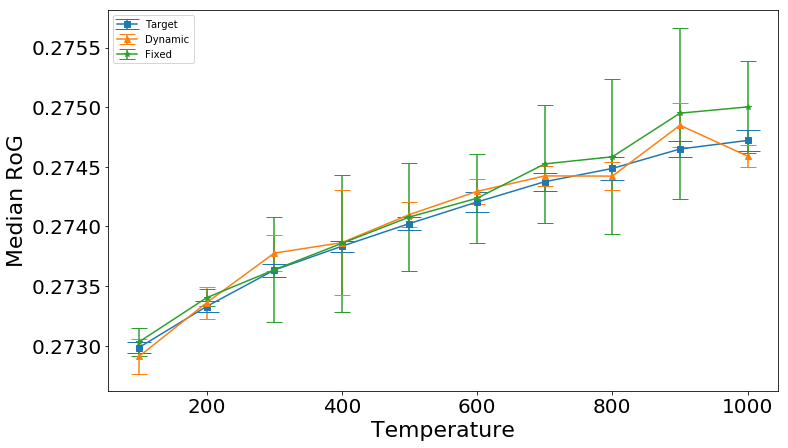

In [251]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,7))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.errorbar(temps,rogs_median,yerr=rogs_std,label='Target', capsize=12.0, fmt="s-")
ax.errorbar(temps_dynLns,rogs_dynLns_median,yerr=rogs_dynLns_std,label='Dynamic', capsize=8.0, fmt="^-")
ax.errorbar(temps_SS,rogs_SS_median,yerr=rogs_SS_std,label='Fixed', capsize=8.0, fmt="*-")
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Median RoG')
plt.savefig('Figures/meadian_ROG.pdf')

## Mean Time vs Temperature

In [252]:
#root_path_hf = '/home/yzamora/proxima/examples/molecule-sampling'
run_name = 'random-seed_runs/runtime_random-seeds/*'
path_str = '/'.join([root_path,run_name])
temp_hf_data =  defaultdict(list)
rs = defaultdict(list)
for d in glob.glob(path_str):
    hf = pd.read_csv(d).set_index("Temp[K]")
    for i in hf.index:
        temp_hf_data[i].append(float(hf.loc[i]))
        

In [253]:
temps_hf = []; runtime_hf_mean = []; runtime_hf_std = []
for i,k in temp_hf_data.items():
    temps_hf.append(float(i))
    runtime_hf_mean.append(np.mean(k))
    runtime_hf_std.append(np.std(k)/np.sqrt(len(k)))
    
temps_hf, runtime_hf_mean, runtime_hf_std = zip(
    *sorted(zip(temps_hf, runtime_hf_mean, runtime_hf_std))
)

## High Fidelity times dataframe

In [254]:
hf_times = pd.DataFrame(
    {
        "Temp[K]": np.array(temps_hf, dtype="int"),
        "Runtime[s]": runtime_hf_mean
    }
)


# Proxima

## Using Reference data

In [255]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## No reference data

In [256]:
results_true = {n: None for n in experiments_true}
for name in results_true:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results_true[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## Fixed Parameters - 0.3, 50
simple surrogate

In [257]:
results_ss = {n: None for n in experiment_ss}
for name in results_ss:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results_ss[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

In [258]:
def summary_speedup(results):
    data_temp = {}
    cols = ["speed_up", "time", "mae"]

    for i,k in results.items():
        data = k.set_index('temperature')
        for t in data.index:

            if t not in data_temp:
                data_temp[t] = defaultdict(list)

            record = data.loc[t]

            for col in cols:
                data_temp[t][col].append(float(record[col]))
    summary = defaultdict(list)
    for i, k in data_temp.items():
        summary["temps"].append(float(i))
        for col in cols:
            summary[col + "_mean"].append(np.mean(k[col]))
            summary[col + "_std"].append(np.std(k[col])/np.sqrt(len(k[col])))

    keys = ["temps"] + [k for k in summary.keys() if k != "temps"]
    result = list(zip(*sorted(zip(*[summary[k] for k in keys]))))
    for i, k in enumerate(keys):
        summary[k] = result[i]
    return summary

In [259]:
summary_with_ref = summary_speedup(results)
summary_no_ref = summary_speedup(results_true)
summary_noref_fixed = summary_speedup(results_ss)

In [260]:
## Harmonic mean of different cases
print('Proxima with reference', stat.harmonic_mean(summary_with_ref['speed_up_mean']))
print('Proxima with no ref. data', stat.harmonic_mean(summary_no_ref['speed_up_mean']))
print('Fixed parameters', stat.harmonic_mean(summary_noref_fixed['speed_up_mean']))


Proxima with reference 2.1493703839392335
Proxima with no ref. data 1.6470570310896486
Fixed parameters 2.332458160213396


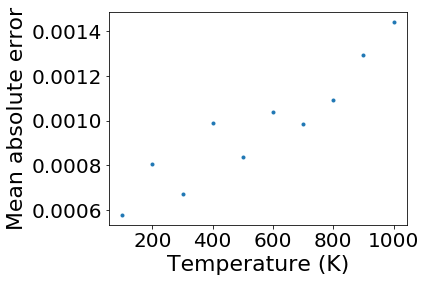

In [261]:
labels = list(summary_no_ref['temps'])
x = np.arange(len(labels)) 
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xlabel("Temperature (K)", fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.plot(summary_no_ref['temps'],summary_no_ref['mae_mean'], '.')

plt.tight_layout()

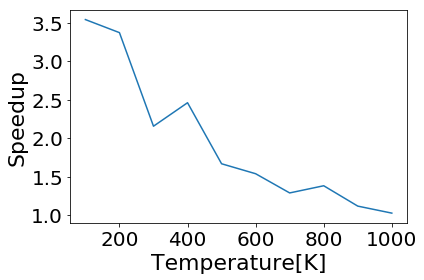

In [262]:
labels = list(summary_no_ref['temps'])
x = np.arange(len(labels)) 
plt.ylabel('Speedup', fontsize=BIG)
plt.xlabel("Temperature[K]", fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.plot(summary_no_ref['temps'],summary_no_ref['speed_up_mean'])

plt.tight_layout()

## Comparing Speed-ups Proxima versions
Reference data vs no ref. data vs fixed surrogate without reference data

In [263]:
from scipy.stats import sem

def graph_speedup(RI, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(summary_no_ref['temps'])

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    
    #find error
    
    rects1 = ax.bar(x - WIDTH/2, list(_speedup_da), WIDTH,yerr=sem(list(_speedup_da)), label='Ref Data')
    rects2 = ax.bar(x + WIDTH/2, list(_speedup_sa), WIDTH,yerr=sem(list(_speedup_sa)), label='No Ref Data')
    if RI:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH, list(_speedup_ss300), WIDTH,yerr=sem(list(_speedup_ss300)), label=r'Fixed, $T$=0.3, $RI$=50')
    else:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH, list(_speedup_ssnort), WIDTH,yerr=sem(list(_speedup_ssnort)), label=r'Fixed, $T$=0.3, $RI$=50')

    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    """if RI:
        plt.savefig('Figures/speedup_best.pdf')
    else:
        plt.savefig('Figures/nort_speedup_bar.pdf')"""

    plt.show()

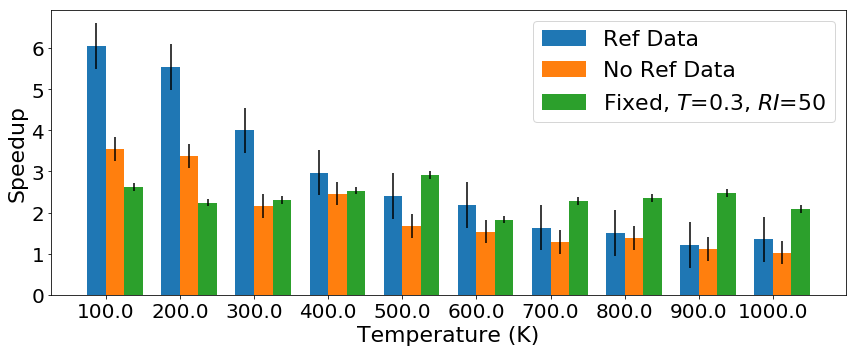

In [264]:
graph_speedup(False, summary_with_ref['speed_up_mean'], summary_no_ref['speed_up_mean'], None,summary_noref_fixed['speed_up_mean'])

## Speedups of Proxima vs Fixed
No Reference data

In [265]:
def graph_speedup(RI, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(summary_no_ref['temps'])

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    
    #calculating error
    
    rects1 = ax.bar(x - WIDTH/2, list(_speedup_da['speed_up_mean']), WIDTH,yerr=_speedup_da['speed_up_std'], label='Proxima - no Ref. Data')
    rects2 = ax.bar(x + WIDTH/2, list(_speedup_sa['speed_up_mean']), WIDTH,yerr=_speedup_sa['speed_up_std'] ,label='Fixed - no Ref. Data')

    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    """if RI:
        plt.savefig('Figures/speedup_best.pdf')
    else:
        plt.savefig('Figures/nort_speedup_bar.pdf')"""

    plt.show()

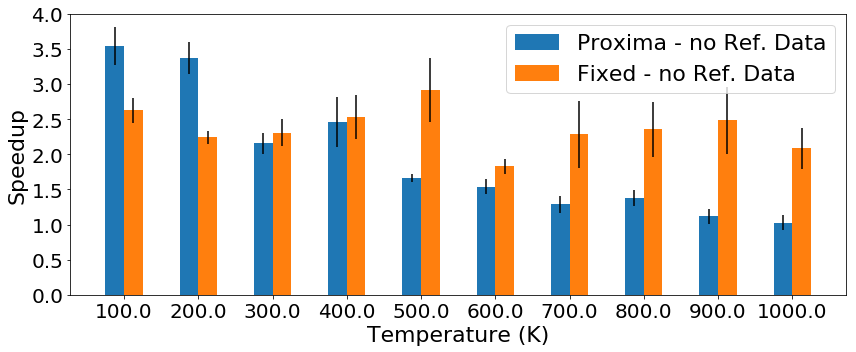

In [266]:
graph_speedup(False, summary_no_ref,summary_noref_fixed ,None, None)

## MAE of results

In [267]:
def mae_results(summary1,summary2):
    RI= True #set true or false depending on retrain interval usage
    SS = False #Comparing with simple surrogate

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    rects1 = ax.bar(x - WIDTH/2, list(summary1['mae_mean']), WIDTH,yerr=summary1['mae_std'], label=r'Proxima - no Ref. Data')
    rects2 = ax.bar(x + WIDTH/2, list(summary2['mae_mean']), WIDTH, yerr=summary2['mae_std'],label='Fixed - no Ref. Data')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean absolute error', fontsize=BIG)
    ax.set_xlabel("Temperature (K)", fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    #plt.savefig('Figures/3prox_MAEbar.pdf')

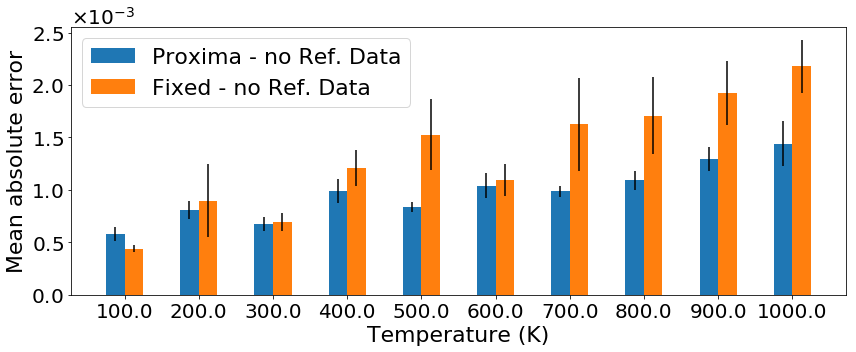

In [268]:
mae_results(summary_no_ref,summary_noref_fixed)